# Wheat Market Analysis
## ARIMA Notebook

### Matthew Garton - October 2018

**Purpose:** The purpose of this notebook is to build some simple ARIMA models using my Wheat Futures Price data. These should serve as a baseline for the more sophisticated models I hope to build. 

**Context**: The ultimate goal of my project is to develop a trading strategy for commodity futures, which will include both prediction modeling to identify price patterns and trading opportunities as well as a rules-based algorithm to make trading decisions and manage risk.

Before experimenting with different models, I want to see what a simple ARIMA time series model can do with this data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import AR, ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from sklearn.metrics import r2_score

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
# read in the dataset
wheat = pd.read_csv('../data/wheat_final_modeling.csv', index_col='Date', parse_dates=True)

In [4]:
wheat.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,5dma,10dma,...,60d_parkinson,90d_parkinson,120d_parkinson,240d_parkinson,360d_parkinson,Turning_Point_Top,Turning_Point_Unclassified,Regime_Flat,Regime_Unclassified,Regime_Up
Date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,195.7,196.7,195.7,196.4,NaN,196.4,5828.0,25273.0,196.400000,196.400000,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0
1959-07-02,196.3,197.4,196.3,197.1,NaN,197.1,4780.0,26524.0,196.820000,196.785000,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0
1959-07-06,196.6,197.6,196.6,197.0,NaN,197.0,6591.0,27452.0,196.905263,196.871429,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0
1959-07-07,197.3,197.5,196.7,197.1,NaN,197.1,5604.0,28749.0,196.986154,196.946733,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0
1959-07-08,197.2,197.4,196.3,196.4,NaN,196.4,4538.0,30527.0,196.761137,196.789781,...,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0


## Find the correct value of $d$: Dickey-Fuller Tests

The first step in my model design is to find the appropriate level of differencing (the hyperparameter $d$ in ARIMA-based models) in order to ensure stationarity. In order to find the optimal value of $d$, I built a function to essentially 'gridsearch' p-values of Dickey-Fuller Tests over possible values of $d$ (I tested all integers 1-100, but for computational efficiency, I am only demonstrating the search between 1 and 10 here). What I found was that a value of 1 was the best, so I use 1 for differencing in my models below.

In [5]:
dickey_fuller_test = adfuller(wheat['Settle'])

In [6]:
def dickey_fuller_output(dftest):
    '''Produces a clean output of Dickey-Fuller test'''
    
    # Store test results as a dict
    results = {'Test Statistic': dftest[0],
          'P-Value': dftest[1],
          'Lags Used': dftest[2],
          'Num obs': dftest[3],
          'Max IC': dftest[5]}
    
    crit_val = dftest[4]
    
    # Create dataframes of the results
    df = pd.DataFrame([results]).T
    df.columns = (['Dickey Fuller Test'])
    display(df)
    
    df2 = pd.DataFrame([crit_val]).T
    df2.columns = (['Critical Values'])
    display(df2)

In [7]:
dickey_fuller_output(dickey_fuller_test)

,Dickey Fuller Test
Lags Used,38.000000
Max IC,105032.068644
Num obs,14900.000000
P-Value,0.053883
Test Statistic,-2.831726


,Critical Values
1%,-3.430789
10%,-2.566873
5%,-2.861734


In [8]:
def d_search(df, drange, column='Settle'):
    '''Find the correct value of d to use for an ARIMA-based model, by performing
    Dickey-Fuller Tests over a range of possible difference levels'''
    
    p_values = []
    
    # check the time series with no differencing
    dftest = adfuller(df[column])
    p_value = tuple([0, dftest[1]])
    p_values.append(p_value)
    
    # For each level of differencing, run a Dicker-Fuller Test and store
    # the values of d and the p-value of the test in a list of tuples
    for d in drange:
        series = df[column].diff(d)
        dftest = adfuller(series.dropna())
        p_value = tuple([d, dftest[1]])
        p_values.append(p_value)
    
    my_dict = dict(p_values) # Turn the list of tuples into a dictionary
    opt_d = min(my_dict, key=my_dict.get) # find the d with the lowest p
    
    return opt_d

In [10]:
drange = list(range(1, 10))

d = d_search(wheat, drange)

In [11]:
d

1

## Autocorrelation Plots

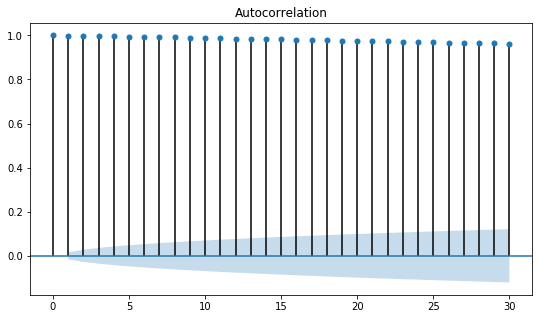

In [18]:
fig, ax = plt.subplots(figsize = (9,5))
plot_acf(wheat['Settle'], lags = 30, ax = ax)
plt.show();

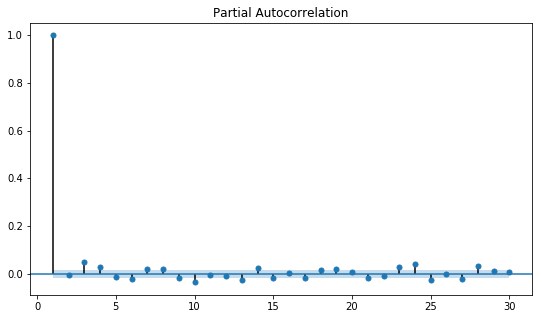

In [19]:
fig, ax = plt.subplots(figsize = (9,5))
plot_pacf(wheat['Settle'], lags=30, ax=ax, zero=False)
plt.show();

### Now checking for ACF and PACF of returns...

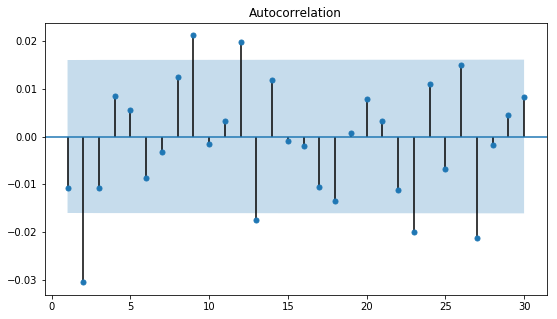

In [20]:
fig, ax = plt.subplots(figsize = (9,5))
plot_acf(wheat['Settle'].pct_change().dropna(), lags=30, ax=ax, zero=False)
plt.show();

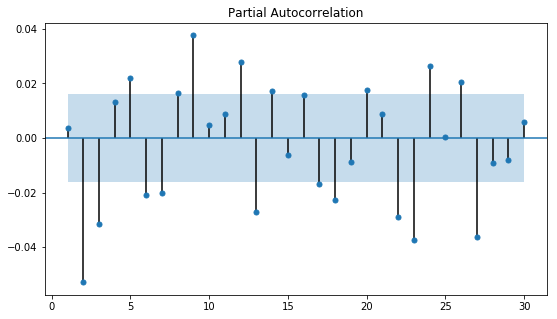

In [21]:
fig, ax = plt.subplots(figsize = (9,5))
plot_pacf(wheat['Settle'].diff().dropna(), lags=30, ax=ax, zero=False)
plt.show();

### Volatility

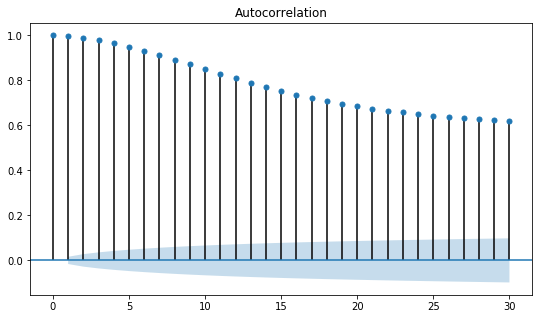

In [22]:
fig, ax = plt.subplots(figsize = (9,5))
plot_acf(wheat['30d_vol'].dropna(), lags = 30, ax = ax)
plt.show();

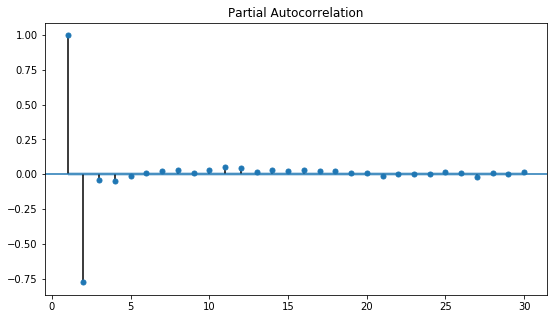

In [23]:
fig, ax = plt.subplots(figsize = (9,5))
plot_pacf(wheat['30d_vol'].dropna(), lags=30, ax=ax, zero=False)
plt.show();

## Scoring Metric: Akaike's Information Criterion (AIC)

For all models below, I evaluate in two ways, one quantitative and one qualitative. Something I learned from trial and error is that $R^2$ does not seem to be a reliable metric for time series models. The $R^2$ values I found in my models were close to 1 on training data and varied wildly on testing data. On testing data, they were consistently below zero. This is not entirely surprising given the well-known tendency of AR models to overfit. However, looking at plots of predictions versus actual testing data, the models were not entirely useless, they just couldn't predict with precision. Also, there was a limit to how far forward the models could predict with any reasonably margin for error.

In order to evaluate the usefulness of a model in a general sense, I did more qualitative analysis, visualizing the predictions versus the testing data. This would quickly tell me if the model should be thrown out, or if it had some limited use. Furthermore, it would tell me how far forward, if at all, the model could reasonably predict.

I used a quantitative metric, Akaike's Information Criterion (AIC) in order to select between models. This is relative metric and doesn't provide useful information as to whether one model is good or bad, but it can tell me if one model is better than another - lower values of AIC indicate better models.

**Formula for AIC:**


$$AIC = 2k + n Log\bigg(\frac{RSS}{n}\bigg)$$


Below, I built a function to 'gridsearch' for optimal values of $p$ and $q$ in my time series models, optimizing for the lowest value of AIC when fitting a ($p$, $d$, $q$) ARIMA model.

In [9]:
def find_optimal_p_q(series):
    '''Gridsearch over possible values of p and q for an ARIMA model to find the
    combination which produces the lowest AIC score'''
    
    import itertools
    p = q = range(0, 30, 10)
    d = [1]

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    series.index = pd.DatetimeIndex(series.index.values,
                               freq=series.index.inferred_freq)
    
    for param in pdq:
        try:
            mod = ARIMA(series.values, order=param)
            results = mod.fit()
            print('Orders{}: AIC  {}'.format(param, results.aic))
        except:
            print('Orders{}: excepted'.format(param))
            continue

In [28]:
find_optimal_p_q(wheat['Settle'])

Orders(0, 1, 0): AIC  105462.9957649617
Orders(0, 1, 10): AIC  105372.14104218711
Orders(0, 1, 20): AIC  105357.8287611063
Orders(10, 1, 0): AIC  105377.80636890084
Orders(10, 1, 10): excepted
Orders(10, 1, 20): excepted
Orders(20, 1, 0): AIC  105347.79386924053
Orders(20, 1, 10): AIC  105266.60734648586
Orders(20, 1, 20): excepted


It appears that larger values of $p$ and $q$ are slightly better, based on gridsearching alone. I actually had more luck with trial and error on fitting different ARIMA and SARIMAX models to find better values of $p$ and $q$. What I noticed was that in order to pick up any kind of pattern and to avoid being overly influenced by the most recent observations, it was important to use large values of $p$ and $q$ ($p$ in particular). This makes sense - if there is a pattern to detect, my model needs enough 'memory' to detect that pattern. Otherwise I am essentially extrapolating a Markov process and getting essentially random results.

In [10]:
def prepare_data(df, start, end, column='Settle', hold_out=0.2):
    '''Prepare data for modeling, selecting a train test split'''
    
    # Select a subset of the data
    df_sample = df[start:end]
    
    # Train Test Split
    test_size = round(df_sample.shape[0] * hold_out)
    train_size = df_sample.shape[0] - test_size
    
    train = df_sample.head(train_size)
    test = df_sample.tail(test_size)
    
    # Re-index the data
    train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
    test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)

    # Get values and corresponding dates
    endog = train[column].values
    train_dates = train.index

    test_values = test[column].values
    test_dates = test.index
    
    return train, test, endog, train_dates, test_values, test_dates

# Note: Choosing the Sample

The values entered for `start`, `end`, and `hold_out` in the `prepare_data()` function will determine which window of time is used for all models below. I would encourage the reader to experiment with different time periods and train test splits, as results do in fact differ depending on time period and location of train test split. This is certainly a weakness in the modeling, but examining the different successes and failures can, I believe, provide some useful insights into how to evaluate and ultimately improve the modeling framework.

In [12]:
train, test, endog, train_dates, test_values, test_dates = prepare_data(wheat, start='2014', end='2015')

## AR Models

To start, I will fit some very basic AR($p$) models. First, I'll fit the most basic, AR(1), because the autocorrelation plot shows a sharp dropoff after lag = 1. I expect this model to overfit on training data and be of limited use for predictions.

In [15]:
# AR(1) Model

ar1 = ARMA(endog=endog, dates=train_dates, freq='B', order=(1,0)) 

model = ar1.fit()
preds = model.predict(start=1, end=len(test_values))
preds = model.forecast(steps=len(test_dates))[0]
print('R_2 Score: {}\n'.format(round(r2_score(test_values[0:5], preds[0:5]), 2)))
print('AIC: {}'.format(round(model.aic)))

R_2 Score: -0.37

AIC: 3028


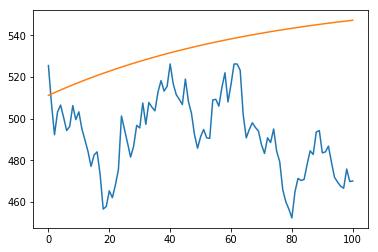

In [18]:
plt.plot(test_values)
plt.plot(preds);

## MA Models

I don't expect moving average models to be as useful, because the data is clearly not stationary.

In [19]:
# MA(1) Model

ma1 = ARMA(endog = wheat['Settle'].astype('float64'), 
           order = (0,1)) 

model = ma1.fit()
preds = model.predict()
model.aic

175173.5681366807

In [19]:
for i in range(0,2):
    for j in range(0,2):
        try:
            ma = ARMA(endog = wheat.iloc[j:,]['Settle'].astype('float64'), 
              order = (i,j)) 
            model = ma.fit()
            preds = model.predict()
            print('MA({}) AIC: {}'.format(i, round(model.aic), 4))
        except:
            print('MA({}) Failed'.format(i,j))

MA(0) AIC: 194759.0
MA(0) AIC: 175162
MA(1) AIC: 105475
MA(1) AIC: 105471


As expected, simple Moving Average models are not a helpful framework for this problem. I will move on to trying some different iterations of ARIMA-based models to see if combining the different approaches is helpful.

## ARIMA Models

In [20]:
arima = ARIMA(endog=endog, order=(1, 1, 0))
model = arima.fit()
preds = model.predict()
forecasts, stderr, conf_int = model.forecast(test_values.shape[0])
model.aic

3018.6534906535117

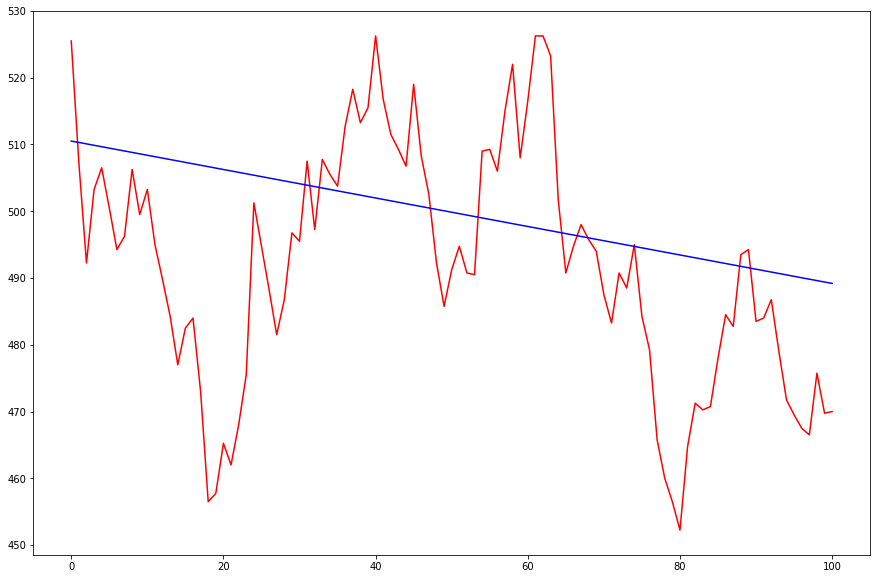

In [21]:
plt.figure(figsize = (15,10))
plt.plot(test_values, color='r')
plt.plot(forecasts, color='b');

# ARIMA Models using SARIMAX Functionality

**Technical Note**
I am using the SARIMAX Functionality here due to bugs I ran into with statsmodels' ARIMA package. Some combinations of ($p$, $d$, $q$) did not work with ARIMA, but I can use the SARIMAX function with all seasonal orders set to 0 to get an ARIMA model (below, I exend my analysis to fit SARIMAX models, but for now I'm focusing on ARIMA). As per my description above (re: gridsearching for $p$ and $q$), I will try to fit some models with higher orders of $p$ and $q$, in an attempt to pick up a pattern in the price history.

In [20]:
arima = SARIMAX(endog=endog, order=(15, 1, 15), enforce_invertibility=False, enforce_stationarity=False)
model = arima.fit()
preds = model.predict()
forecasts = model.forecast(test_values.shape[0])
model.aic

2921.1540786125183

In [21]:
r2_score(test_values[0:5], forecasts[0:5])

-1.483713831636822

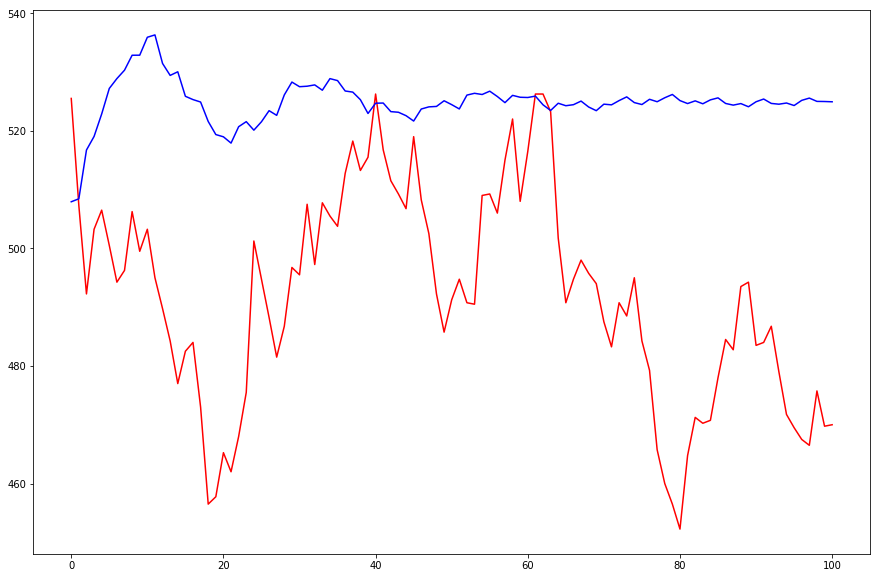

In [22]:
plt.figure(figsize = (15,10))
plt.plot(test_values, color='r')
plt.plot(forecasts, color='b');

# SARIMAX Models

Below is a SARIMAX model which works significantly better than any of the above. While not perfect, it has some predictive value over a short enough forecast horizon while being simple enough to interpret. I used the following values of ($p$, $d$, $q$) and ($P$, $D$, $Q$, $S$):

$$(p, d, q) = (20, 1, 15)$$

$$(P, D, Q, S) = (1, 1, 1, 4)$$


along with the following exogenous variables:

    -Volume 
    -30 Day Historical Volatility 
    -30 Day Parkinson Ratio 
    -Dummy Variables for Regime (Flat, Unclassified, Up) with Down as the excluded category.

In [13]:
sarimax = SARIMAX(endog=endog, 
                  exog=(train[['Volume','30d_vol','30d_parkinson',
                                      'Regime_Flat', 'Regime_Unclassified', 'Regime_Up']].values),
                  order=(20, 1, 15), seasonal_order=(1, 1, 1, 4), 
                  enforce_invertibility=False, enforce_stationarity=False)
model = sarimax.fit()
preds = model.predict(start=1, end=len(test_dates), dynamic=True)
forecasts = model.forecast(steps=len(test_dates), exog=test[['Volume','30d_vol','30d_parkinson',
                                      'Regime_Flat', 'Regime_Unclassified', 'Regime_Up']].values)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  403
Model:             SARIMAX(20, 1, 15)x(1, 1, 1, 4)   Log Likelihood               -1416.231
Date:                             Tue, 06 Nov 2018   AIC                           2920.462
Time:                                     16:36:24   BIC                           3096.415
Sample:                                          0   HQIC                          2990.121
                                             - 403                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4.989e-05   3.02e-05      1.652      0.098   -9.29e-06       0.000
x2             1.5196      0.557      2.730      0.006       0.429       2.610
x3           470.7923      0.052   9132.879      0.000     470.691     470.893
x4            13.9185     14.326      0.972      0.331     -14.160      41.997
x5             3.2770      4.176      0.785      0.433      -4.909      11.463
x6            10.1907      6.758      1.508      0.132      -3.056      23.437
ar.L1         -0.1006      1.789     -0.056      0.955      -3.607       3.405
ar.L2          0.5444      0.922      0.590      0.555      -1.264       2.352
ar.L3          0.3217      1.507      0.213      0.831      -2.633       3.276
ar.L4         -0.6766      1.345     -0.503      0.615      -3.312       1.959
ar.L5          0.1169      1.405      0.083      0.934      -2.637       2.871
ar.L6          0.6783      0.784      0.866      0.387      -0.858       2.214
ar.L7          0.0150      1.334      0.011      0.991      -2.599       2.629
ar.L8         -0.8676      0.951     -0.913      0.361      -2.731       0.996
ar.L9          0.0570      1.833      0.031      0.975      -3.536       3.650
ar.L10         0.1217      1.071      0.114      0.909      -1.977       2.221
ar.L11         0.1790      0.686      0.261      0.794      -1.165       1.523
ar.L12        -0.0447      1.055     -0.042      0.966      -2.113       2.023
ar.L13         0.0742      0.233      0.318      0.750      -0.383       0.531
ar.L14         0.0383      0.410      0.093      0.926      -0.766       0.843
ar.L15         0.0566      0.222      0.255      0.799      -0.378       0.491
ar.L16        -0.0733      0.278     -0.263      0.792      -0.619       0.473
ar.L17        -0.0793      0.168     -0.472      0.637      -0.409       0.250
ar.L18        -0.1007      0.311     -0.324      0.746      -0.709       0.508
ar.L19         0.0510      0.247      0.206      0.836      -0.433       0.535
ar.L20        -0.0830      0.238     -0.349      0.727      -0.549       0.384
ma.L1          0.2553      1.817      0.140      0.888      -3.306       3.817
ma.L2         -0.4463      1.053     -0.424      0.672      -2.509       1.617
ma.L3         -0.2932      1.398     -0.210      0.834      -3.034       2.448
ma.L4         -0.0681      0.563     -0.121      0.904      -1.171       1.035
ma.L5         -0.3563      0.475     -0.751      0.453      -1.286       0.574
ma.L6         -0.3040      0.778     -0.391      0.696      -1.829       1.221
ma.L7          0.0189      0.775      0.024      0.981      -1.500       1.537
ma.L8          0.4587      0.527      0.871      0.384      -0.574       1.491
ma.L9         -0.0035      0.741     -0.005      0.996      -1.456       1.449
ma.L10         0.4743      0.505      0.939      0.348      -0.516       1.465
ma.L11        -0.2051      0.746     -0.275

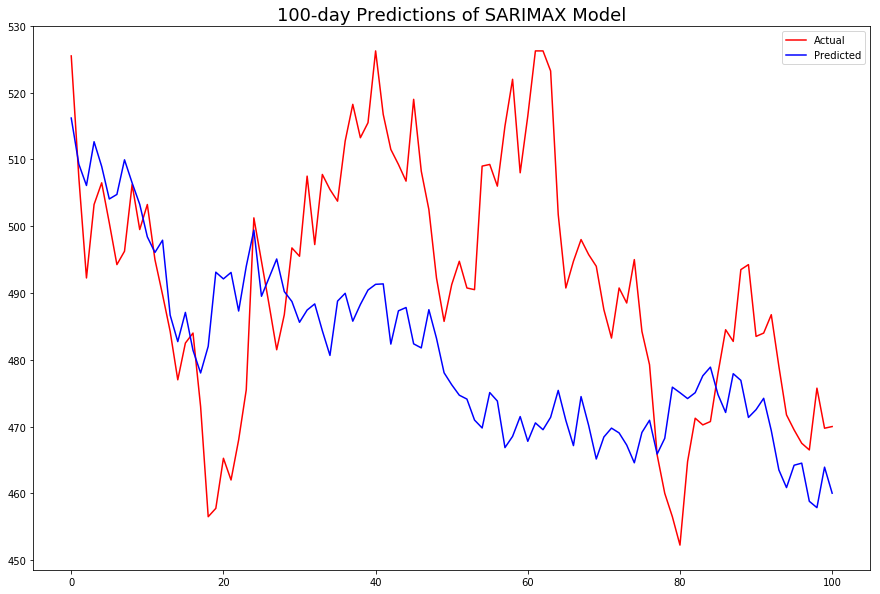

In [14]:
plt.figure(figsize = (15,10))
plt.plot(test_values, color='r', label='Actual')
plt.plot(forecasts, color='b', label='Predicted')
plt.legend()
plt.title('100-day Predictions of SARIMAX Model', fontsize=18);

The plot above shows the potential for predictive power with a SARIMAX model with high orders of $p$ and $q$, and exogenous variables which I previously found to be positively correlated with price (see EDA - specifically PairGrids plot). The predictions more or less track the actual prices up to 5 or 10 days out (in this case, they actually seem decent up to closer to 20 days) and break down after that. I would expect to not be able to predict further out than the model can look back. One important note, which is not fully highlighted here, is that the model's performance is not robust to training/testing sets. That is to say, it does matter which period the model is used in, and the location of the exact train test split matters. For example, in cases where the split occurs at a sharp turning point, the model is particularly bad (as it predicts the opposite trend to what unfolds). The framework needs some dynamic component where the split between training and testing is not so discrete (i.e. some kind of cross validation, or boosting approach, where the model can learn from it's failures and correct).

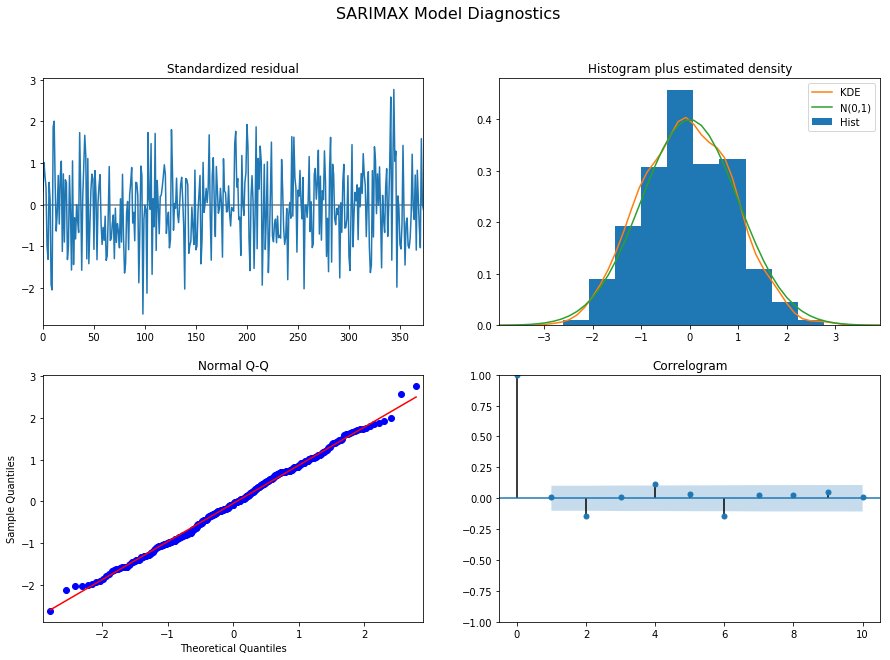

In [15]:
model.plot_diagnostics(figsize=(15,10))
plt.suptitle('SARIMAX Model Diagnostics', fontsize=16);

In summary, AR, MA, ARMA, ARIMA, and SARIMAX models appear to be of limited use in predicting future prices. Within some level of confidence, they appear to be 'OK' at forecasting up to about 10 days out, but fall apart outside of that range. To achieve better predictions, I plan to pursue the following different approaches:

1. A more advanced model, such as a LSTM neural network.
2. Adding more exogenous variables, including technical indicators and outside data (wheather, supply and demand, etc.)
3. Attempting to inforcorate a way for the model to learn from it's predictions. I noticed that, since trends persist once formed, the model's bias often compounds if it goes in the wrong direction. When the model makes a prediction for one period, it should evaluate and then 'overcorrect' if it misses the mark. 
4. Identifying which periods the model works well on versus which periods it fails on, and trying to identify the factors that drive the success or failure, would help me to either refine the model, or know how confident to be in its output.